# Time series 2

In [7]:
# For arrays and other numerical operations
# (any function from this module can be used by typing np.FunctionName)
import numpy as np
import warnings

# For plotting
import matplotlib.pyplot as plt

In [8]:
def check_stability(p, phi):
    poly = np.zeros(p+1)
    poly[0:p] = -phi
    poly[p] = 1
    r = np.roots(poly)
    if any(np.abs(r) <= 1):
        warnings.warn('The process is not stable')
    return r

def plot_process(proc, order, mu, coeff, n, nof, disp_traj=True):
    #
    # Compute realisations of a AR or MA process and displays the trajectories,
    # moments and autocorrelation function
    #
    # Inputs:
    # proc    Name of process (AR or MA)
    # order   Order of the process
    # mu      Mean
    # coeff   Coefficients
    # n       Number of time steps
    # nof     Number of realisations
    # Optional imputs:
    # disp_traj    (bool) Display trajectory of each realisation
    
    # If the process is an AR(p) then stability needs to be checked
    if proc == 'AR':
        check_stability(order, coeff)
    elif not(proc == 'MA'):
        raise Exception('Unknown process type')
    
    # For more than 100 realisations, individual trajectories are not shown
    if nof > 100:
        disp_traj = False
    
    # To avoid boundary effects, the process is initialised earlier
    burn_in = 25 * order
    
    # Computation of the realisations of the process
    y = np.zeros((nof, n+burn_in))
    eps = np.random.randn(nof, n+burn_in)
    for N in range(nof):
        y[N, 0] = mu
        for k in range(1, n+burn_in):
            s = max(k-order, 0)
            if proc == 'AR':
                y[N, k] = mu + np.matmul(coeff[0:k-s], y[N, s:k] - mu) + eps[N, k]
            elif proc == 'MA':
                y[N, k] = mu + np.matmul(coeff[0:k-s], eps[N, s:k]) + eps[N, k]
            else:
                raise Exception('Unknown process type')
        
        # Display trajectories
        if disp_traj:
            plt.plot(y[N, burn_in:n+burn_in], '-', LineWidth=.25, color='k')
            plt.xlabel('time steps')
            plt.ylabel('value');
            
    return y

# Moments
def display_moments(y, n):
    nof = np.size(y, 0)
    burn_in = np.size(y, 1) - n
    mean = np.zeros(n)
    for k in range(burn_in, n+burn_in):
        mean[k-burn_in] = np.sum( y[:, k] ) / nof
    plt.figure()
    plt.plot(mean, label='mean')
    
    if nof > 1:
        std_dev = np.zeros(n)
        for k in range(burn_in, n+burn_in):
            std_dev[k-burn_in] = np.sqrt( np.sum( (y[:, k] - mean[k-burn_in])**2 ) / (nof-1) )
        
        for i in range(2,4):
            plt.fill_between(np.linspace(0,n-1,n),
                     y1=mean-i*std_dev,
                     y2=mean+i*std_dev, color='r', alpha=.1, label='+- {} std dev'.format(i))
    plt.xlabel('time steps')
    plt.ylabel('value')
    plt.legend()

    
# Autocorrelation
def display_acf(y, n, n_acf):
    burn_in = np.size(y, 0) - n
    mean = np.sum( y[burn_in:n+burn_in] ) / n
    var = np.sum( (y[burn_in:n+burn_in] - mean)**2 ) / (n-1)
    #n_acf = int(10)
    acf = np.zeros(n_acf)
    for k in range(n_acf):
        acf[k] = np.sum(np.multiply(y[burn_in:burn_in+n-k] \
                                    - mean, y[burn_in+k:n+burn_in] - mean)) / ((n-k)*var)
    plt.figure()
    plt.plot(acf)
    plt.xlabel('time steps')
    plt.ylabel('autocorrelation')

In [9]:
# Mean
mu = 5
# Number of time steps
n = 500

## Stability of AR(2) process

Delta: 1.56
lambda 1: 0.9244997998398399
lambda 2: -0.32449979983983984
x_1: 3.081665999466133
x_2: -1.0816659994661328


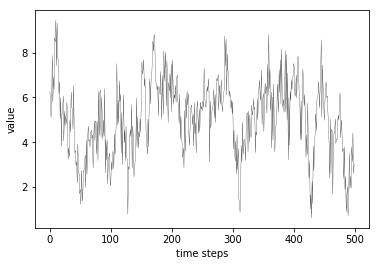

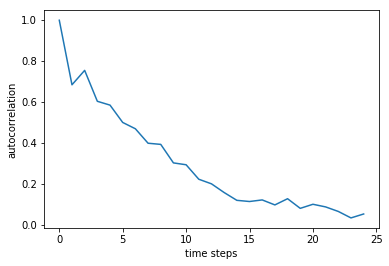

In [14]:
p = 2
phi = np.array([0.6, 0.3])
y = plot_process('AR', p, mu, phi, n, 1)
display_acf(y[0,:], n, 25)

Delta = phi[0]**2 + 4*phi[1]
print('Delta:', Delta)
print('lambda 1:', (phi[0] + np.sqrt(Delta))/2)
print('lambda 2:', (phi[0] - np.sqrt(Delta))/2)
print('x_1:', (phi[0] + np.sqrt(Delta))/(2*phi[1]))
print('x_2:', (phi[0] - np.sqrt(Delta))/(2*phi[1]))

## Differencing: back to the gas sales

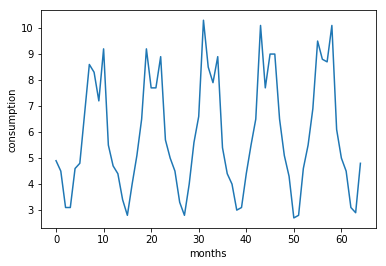

In [16]:
# Array of data (rows are months (January to December) and columns are years)
data = np.array([[0, 8.3, 7.7, 8.5, 7.7, 8.8],
                 [0, 7.2, 7.7, 7.9, 9.0, 8.7],
                 [0, 9.2, 8.9, 8.9, 9.0, 10.1],
                 [0, 5.5, 5.7, 5.4, 6.5, 6.1],
                 [4.9, 4.7, 5.0, 4.4, 5.1, 5.0],
                 [4.5, 4.4, 4.5, 4.0, 4.3, 4.5],
                 [3.1, 3.4, 3.3, 3.0, 2.7, 3.1],
                 [3.1, 2.8, 2.8, 3.1, 2.8, 2.9],
                 [4.6, 4.0, 4.0, 4.4, 4.6, 4.8],
                 [4.8, 5.1, 5.6, 5.5, 5.5, 0],
                 [6.7, 6.5, 6.6, 6.5, 6.9, 0],
                [8.6, 9.2, 10.3, 10.1, 9.5, 0]])

# Reshape the data into one row vector and remove zeros at the start and end
y = (data.T).reshape(1,72)[:, 4:-3]

# All data points are considered for filtering
n = len(y[0, :])

# The period is 12 months
p = 12

# Plot the data
plt.plot(y[0, :])
plt.xlabel('months')
plt.ylabel('consumption');

This is non-stationary: differencing

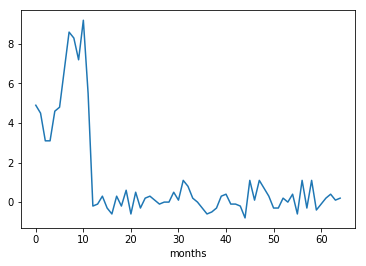

In [6]:
y_diff = np.copy(y)
y_diff[0, p:n] -= y_diff[0, 0:n-p]

# Plot the data
plt.plot(y_diff[0, :])
plt.xlabel('months');

The time series is closer to stationarity now. Note that the differencing only applies after $p$ times steps

## Differencing: another example

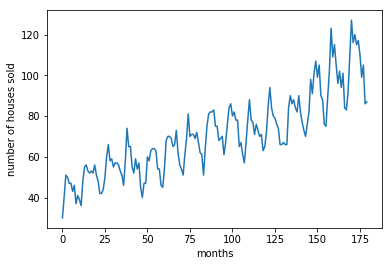

In [17]:
y = np.array([30, 40, 51, 50, 47, 47, 43, 46, 37, 41, 39, 36, 48, 55, 56, 53, 52, 53, 52, 56, 51, 48, 42, 42, 44, 50, 60, 66,
               58, 59, 55, 57, 57, 56, 53, 51, 46, 58, 74, 65, 65, 55, 52, 59, 54, 57, 45, 40, 47, 47, 60, 58, 63, 64, 64, 63,
               54, 54, 46, 45, 54, 68, 70, 70, 69, 65, 66, 73, 62, 56, 54, 51, 61, 69, 81, 70, 71, 71, 69, 72, 67, 62, 61, 51,
               64, 75, 81, 82, 82, 83, 75, 75, 68, 69, 70, 61, 67, 76, 84, 86, 80, 82, 78, 78, 65, 67, 61, 57, 67, 78, 88, 78,
               77, 71, 76, 73, 70, 71, 63, 65, 72, 85, 94, 84, 80, 79, 76, 74, 66, 66, 67, 66, 66, 84, 90, 86, 88, 84, 82, 90,
               82, 77, 73, 70, 76, 82, 98, 91, 101, 107, 99, 105, 90, 88, 76, 75, 89, 102, 123, 109, 115, 105, 96, 102, 94, 101,
               84, 83, 92, 109, 127, 116, 120, 115, 117, 110, 99, 105, 86, 87])

# All data points are considered for filtering
n = len(y)

# The period is 12 months
p = 12

# Plot the data
plt.plot(y)
plt.xlabel('months')
plt.ylabel('number of houses sold');

In [22]:
y_diff = np.copy(y)

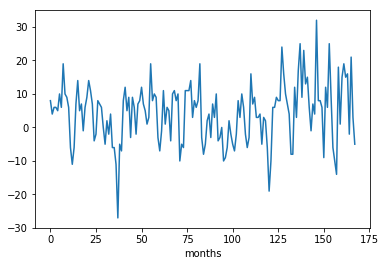

In [23]:
y_diff[p-1:n] -= y_diff[0:n-p+1]

# Plot the data
plt.plot(y_diff[p:n])
plt.xlabel('months');

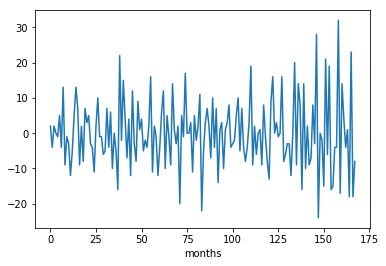

In [24]:
y_diff[1:n] -= y_diff[0:n-1]

# Plot the data
plt.plot(y_diff[p:n])
plt.xlabel('months');